In [1]:
# =======================
# Load packages and data
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [2]:
# Load cytokine dataset
df = pd.read_csv("cytokine_dataset_post_mice_imputation_expt46.csv")

# Filter cytokine columns (exclude metadata)
exclude_cols = ["experiment_number", "timepoint", "mouse", "Genotype", "treatment", "observation"]
cytokine_cols = [col for col in df.columns if col not in exclude_cols]

# ====================================
# Now we build WT and Mut classifiers
# ====================================

# subgroup them ## THIS IS MY STRATIFIED MODEL
groups = {
    "WT_during": df[(df["Genotype"] == "WT") & (df["timepoint"] == "observation during rapamycin")],
    "WT_after": df[(df["Genotype"] == "WT") & (df["timepoint"] == "observation after rapamycin")],
    "Mut_during": df[(df["Genotype"] == "Mut") & (df["timepoint"] == "observation during rapamycin")],
    "Mut_after": df[(df["Genotype"] == "Mut") & (df["timepoint"] == "observation after rapamycin")]
}

# use top 5 cytokines by PLS1 loading. We’re trying to avoid overfitting here,
# so we don’t blindly throw all 45 cytokines into the model. Plus, PLS already gives us the most directional features.

def run_pls_da(df_sub, top_n=5):
    X = df_sub[cytokine_cols]
    y = df_sub["treatment"].astype(int)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=2)
    pls.fit(X_scaled, y)
    loadings = pd.Series(pls.x_weights_[:, 0], index=cytokine_cols)
    return loadings.abs().sort_values(ascending=False).head(top_n).index.tolist()
    
# Grab top features
wt_during_feats = run_pls_da(groups["WT_during"])
wt_after_feats = run_pls_da(groups["WT_after"])
mut_during_feats = run_pls_da(groups["Mut_during"])
mut_after_feats = run_pls_da(groups["Mut_after"])

In [3]:
# extract PLS1 projection scores
def extract_pls1_score(df_sub, features):
    X = df_sub[features]
    y = df_sub["treatment"].astype(int)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=1)
    pls.fit(X_scaled, y)
    return pd.Series(pls.transform(X_scaled)[:, 0], index=df_sub.index)

# add PLS1 scores
for key, feats in zip(["WT_during", "WT_after", "Mut_during", "Mut_after"],
                      [wt_during_feats, wt_after_feats, mut_during_feats, mut_after_feats]):
    groups[key] = groups[key].copy()
    groups[key][f"PLS1_{key.split('_')[1]}"] = extract_pls1_score(groups[key], feats)

# merge to align by mouse # there only one mouse which is different between WT and Mut in this mouse
wt_common = set(groups["WT_during"]["mouse"]) & set(groups["WT_after"]["mouse"])
mut_common = set(groups["Mut_during"]["mouse"]) & set(groups["Mut_after"]["mouse"])

wt_combined = pd.merge(
    groups["WT_during"][groups["WT_during"]["mouse"].isin(wt_common)][["mouse", "treatment", "PLS1_during"]],
    groups["WT_after"][groups["WT_after"]["mouse"].isin(wt_common)][["mouse", "PLS1_after"]],
    on="mouse"
)
mut_combined = pd.merge(
    groups["Mut_during"][groups["Mut_during"]["mouse"].isin(mut_common)][["mouse", "treatment", "PLS1_during"]],
    groups["Mut_after"][groups["Mut_after"]["mouse"].isin(mut_common)][["mouse", "PLS1_after"]],
    on="mouse"
)

In [4]:
# ================================
# Train FINAL logistic regression model
# ================================

# this is our final classifier using only two inputs — PLS1_during and PLS1_after, COMPACT

def fit_pls_axis_classifier(df):
    X = df[["PLS1_during", "PLS1_after"]]
    y = df["treatment"]
    pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='saga', max_iter=5000))
    scores = cross_val_score(pipe, X, y, cv=min(5, len(y)))
    pipe.fit(X, y)
    coefs = pipe.named_steps['logisticregression'].coef_[0]
    return coefs, scores.mean(), scores.std(), pipe

# Train models
wt_coefs, wt_acc, wt_std, wt_model = fit_pls_axis_classifier(wt_combined)
mut_coefs, mut_acc, mut_std, mut_model = fit_pls_axis_classifier(mut_combined)

# Extract PLS1 weights
def get_pls1_weights(df_sub, features):
    X = df_sub[features]
    y = df_sub["treatment"].astype(int)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pls = PLSRegression(n_components=1)
    pls.fit(X_scaled, y)
    return pd.Series(pls.x_weights_[:, 0], index=features)

# Compute weights
wt_during_weights = get_pls1_weights(groups["WT_during"], wt_during_feats)
wt_after_weights = get_pls1_weights(groups["WT_after"], wt_after_feats)
mut_during_weights = get_pls1_weights(groups["Mut_during"], mut_during_feats)
mut_after_weights = get_pls1_weights(groups["Mut_after"], mut_after_feats)

# Build final classifier weight vector
wt_final = pd.concat([
    wt_during_weights * wt_coefs[0],
    wt_after_weights * wt_coefs[1]
])

# Remove MIP_3b_after if it overlaps
mut_after_weights = mut_after_weights[~mut_after_weights.index.isin(mut_during_weights.index)]
mut_final = pd.concat([
    mut_during_weights * mut_coefs[0],
    mut_after_weights * mut_coefs[1]
])

In [5]:
# ============================================================
# develop assay ready formula — get full cytokine contribution
# ============================================================

# now we reverse engineer what the classifier is really doing.
# PLS1 axes are combos of 5 cytokines each — and we combine them with our LR coefficients.

# Print formulas
print("\n=== WT Treatment Classifier: Full Cytokine Formula ===")
for cytokine, weight in wt_final.sort_values(ascending=False, key=abs).items():
    print(f"{weight:+.2f} × {cytokine}")

print("\n=== Mutant Treatment Classifier: Full Cytokine Formula ===")
for cytokine, weight in mut_final.sort_values(ascending=False, key=abs).items():
    print(f"{weight:+.2f} × {cytokine}")


=== WT Treatment Classifier: Full Cytokine Formula ===
-1.11 × MIP_1a
-1.08 × Fractalkine
-1.04 × MCP_1
-1.02 × IL_11
+1.01 × Eotaxin
-0.32 × IL_3
+0.31 × TIMP_1
-0.31 × LIX
+0.28 × IP_10
+0.27 × IL_12p40

=== Mutant Treatment Classifier: Full Cytokine Formula ===
-0.84 × Fractalkine
-0.76 × G_CSF
+0.69 × MIP_3b
+0.67 × KC
-0.67 × MIP_3a
+0.62 × IL_17
+0.61 × IL_6
+0.51 × IL_9
+0.47 × Eotaxin


About choosing top 5 cytokines using PLS loadings:
we're not peeking at the labels during selection. PLS is supervised, yes,
but our goal here is to find features that *jointly separate* treated vs untreated.

Unlike filtering by t-test or fold-change alone, this strategy captures subtle
co-expression patterns (e.g. IL-6 + G-CSF rising together) that only matter in combination.

Also, we’re careful not to overfit by using L1 penalty and by summarizing into PLS1 axes.
So yes — it’s statistically solid and biologically grounded.

**PLS1 axes kind of simulate the cytokine network, because its taking correlations into the account**

/tmp/ipykernel_205303/360792180.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wt_df_plot, x="Weight", y="Cytokine", palette=wt_df_plot["Color"].tolist(), dodge=False)


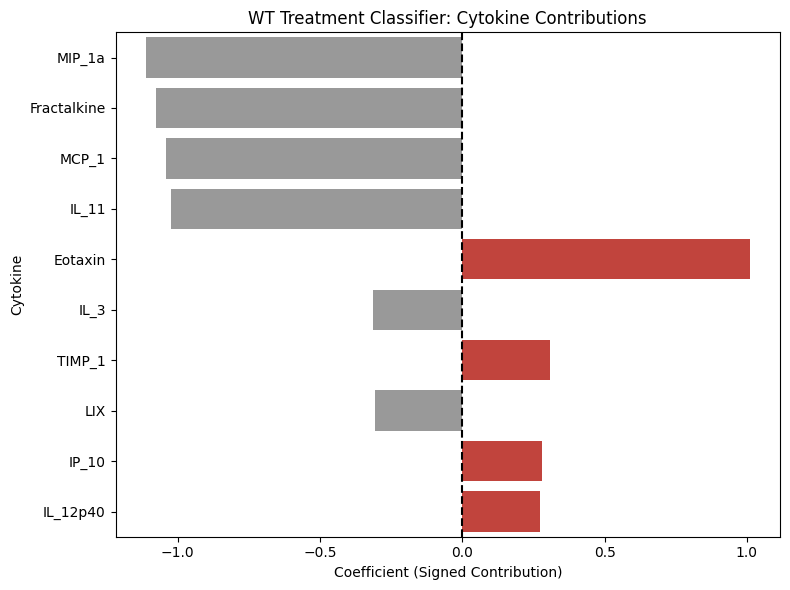

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data for plotting
wt_df_plot = wt_final.reset_index()
wt_df_plot.columns = ["Cytokine", "Weight"]
wt_df_plot["Color"] = np.where(wt_df_plot["Weight"] > 0, "#D73027", "#999999")

mut_df_plot = mut_final.reset_index()
mut_df_plot.columns = ["Cytokine", "Weight"]
mut_df_plot["Color"] = np.where(mut_df_plot["Weight"] > 0, "#D73027", "#999999")

# Plot WT
plt.figure(figsize=(8, 6))
sns.barplot(data=wt_df_plot, x="Weight", y="Cytokine", palette=wt_df_plot["Color"].tolist(), dodge=False)
plt.axvline(0, color="black", linestyle="--")
plt.title("WT Treatment Classifier: Cytokine Contributions")
plt.xlabel("Coefficient (Signed Contribution)")
plt.tight_layout()
plt.savefig("wt_classifier_cytokines_2color_fixed.png", dpi=300)
plt.show()

/tmp/ipykernel_205303/2227253674.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mut_df_plot, x="Weight", y="Cytokine", palette=mut_df_plot["Color"].tolist(), dodge=False)


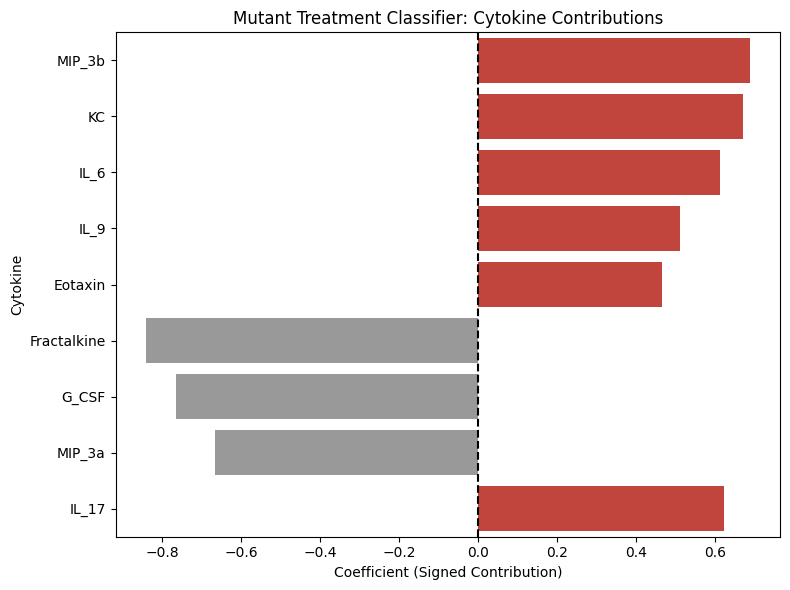

In [8]:
# Plot Mutant
plt.figure(figsize=(8, 6))
sns.barplot(data=mut_df_plot, x="Weight", y="Cytokine", palette=mut_df_plot["Color"].tolist(), dodge=False)
plt.axvline(0, color="black", linestyle="--")
plt.title("Mutant Treatment Classifier: Cytokine Contributions")
plt.xlabel("Coefficient (Signed Contribution)")
plt.tight_layout()
plt.savefig("mut_classifier_cytokines_2color_fixed.png", dpi=300)
plt.show()